In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
# PARAMETERS
run_id="DMRs.07.23.ldcts"

In [3]:
# Parameters
run_id = "hyper_DMRs.09.26.ldcts"


In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df.head()

/tmp/ipykernel_4074536/1445883874.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,OT_Granular_GABA,2.882988e-08,2.786034e-08,0.150381,Wightman.NatGenet.2021.Alzheimers_,0.822806
1,Astrocyte,1.193795e-08,1.187829e-08,0.157443,Wightman.NatGenet.2021.Alzheimers_,0.802877
2,SMC,4.096925e-08,4.136168e-08,0.160962,Wightman.NatGenet.2021.Alzheimers_,0.793277
3,STR_D1_MSN,4.372344e-08,5.216996e-08,0.200988,Wightman.NatGenet.2021.Alzheimers_,0.696829
4,STR_D2_MSN,1.703692e-08,4.066926e-08,0.337639,Wightman.NatGenet.2021.Alzheimers_,0.471547


In [6]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [7]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [8]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

310     0.571969
3472    0.571969
3473    0.571969
3474    0.571969
3163    0.571969
          ...   
1497    0.999985
1498    0.999985
1499    0.999985
1487    0.999985
3781    0.999985
Name: FDR_BH_corrected, Length: 3782, dtype: float64


In [9]:
print(adj_pval.sort_values())

2083    0.571969
3318    0.574334
408     0.575492
1121    0.576683
775     0.578932
          ...   
76      1.063497
1612    1.222100
217     1.319725
1860    1.339387
3503    2.067454
Name: adj_pval, Length: 3782, dtype: float64


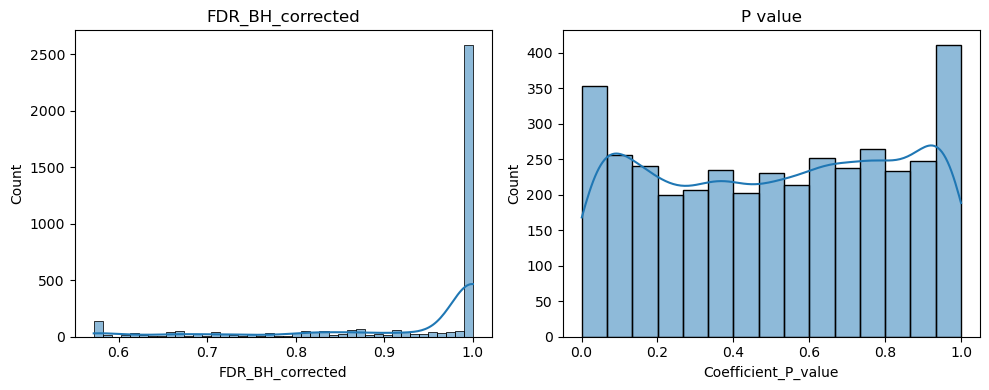

In [10]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [11]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.541231,0.019271,0.041597,0.214914,0.018543,0.237224,0.234667,0.814241,0.574723,0.052434,...,0.809420,0.016182,0.044203,0.096985,0.004060,0.008562,1.720430,0.322650,0.409588,0.023988
Astrocyte,0.188489,1.773701,0.566695,0.269300,0.763723,0.179631,0.083122,0.012606,0.116367,1.024668,...,0.006051,1.394515,0.025329,0.070461,0.066335,0.117355,0.281645,0.921683,0.032187,0.426896
CN_Cholinergic_GABA,1.631479,0.014973,0.105053,0.122187,0.071241,0.034649,0.393307,0.481427,0.593162,0.242572,...,0.696301,0.000371,0.552317,0.173526,0.043067,0.074797,0.901343,1.133025,0.066613,0.453828
CN_GABA-Glut,1.189677,0.104982,0.291537,0.110770,0.645444,0.111196,0.403429,0.320255,0.935305,0.033515,...,1.231411,0.000508,1.102542,0.126491,0.215738,0.477532,0.703937,1.221879,0.214416,0.946808
CN_LAMP5-CXCL14_GABA,1.628855,0.010899,0.056650,0.174762,0.020601,0.031222,0.318077,0.925971,0.461026,0.254442,...,0.994988,0.000013,0.751821,0.285149,0.140446,0.296950,1.990678,0.774991,0.049490,0.287726


In [12]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.972575,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,0.848603,0.957038,0.999985,...,0.850110,0.999985,0.999985,0.999985,0.999985,0.999985,0.571969,0.999985,0.999985,0.999985
Astrocyte,0.999985,0.571969,0.957038,0.999985,0.866525,0.999985,0.999985,0.999985,0.999985,0.771248,...,0.999985,0.653957,0.999985,0.999985,0.999985,0.999985,0.999985,0.813423,0.999985,0.999985
CN_Cholinergic_GABA,0.587451,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,0.995395,0.945222,0.999985,...,0.890128,0.999985,0.963317,0.999985,0.999985,0.999985,0.821525,0.719735,0.999985,0.998103
CN_GABA-Glut,0.710372,0.999985,0.999985,0.999985,0.917074,0.999985,0.999985,0.999985,0.813423,0.999985,...,0.687588,0.999985,0.728443,0.999985,0.999985,0.995395,0.887068,0.687588,0.999985,0.812696
CN_LAMP5-CXCL14_GABA,0.587451,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,0.813423,0.995395,0.999985,...,0.787236,0.999985,0.867572,0.999985,0.999985,0.999985,0.571969,0.858180,0.999985,0.999985


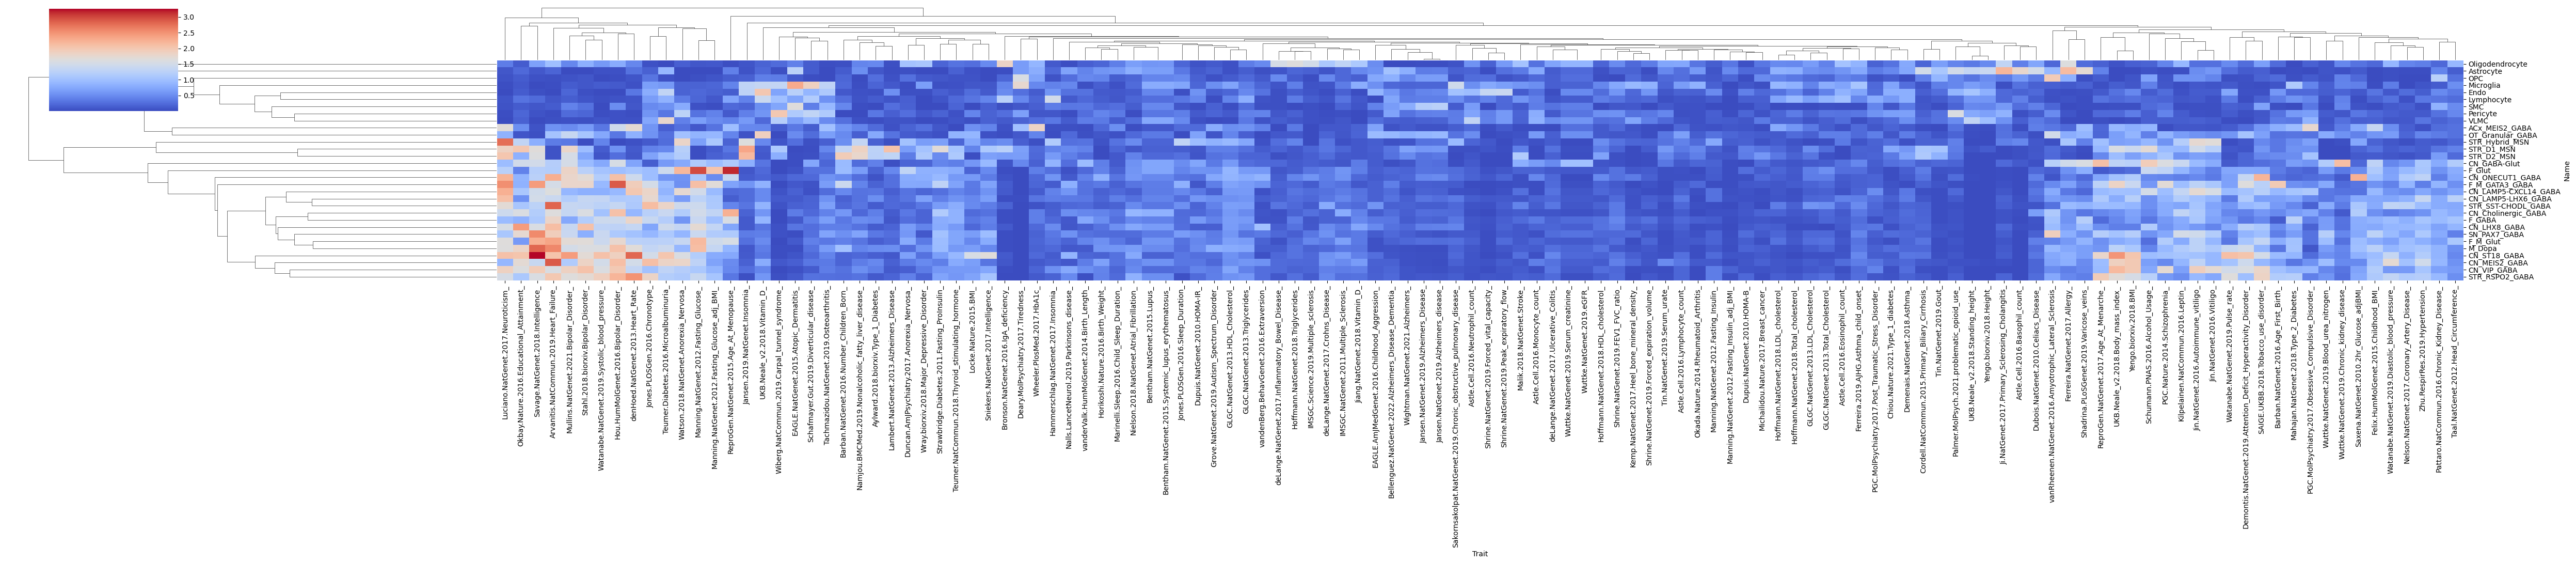

In [13]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(50, 11))

plt.show()
g.savefig(f'output/{run_id}.pdf')

In [14]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

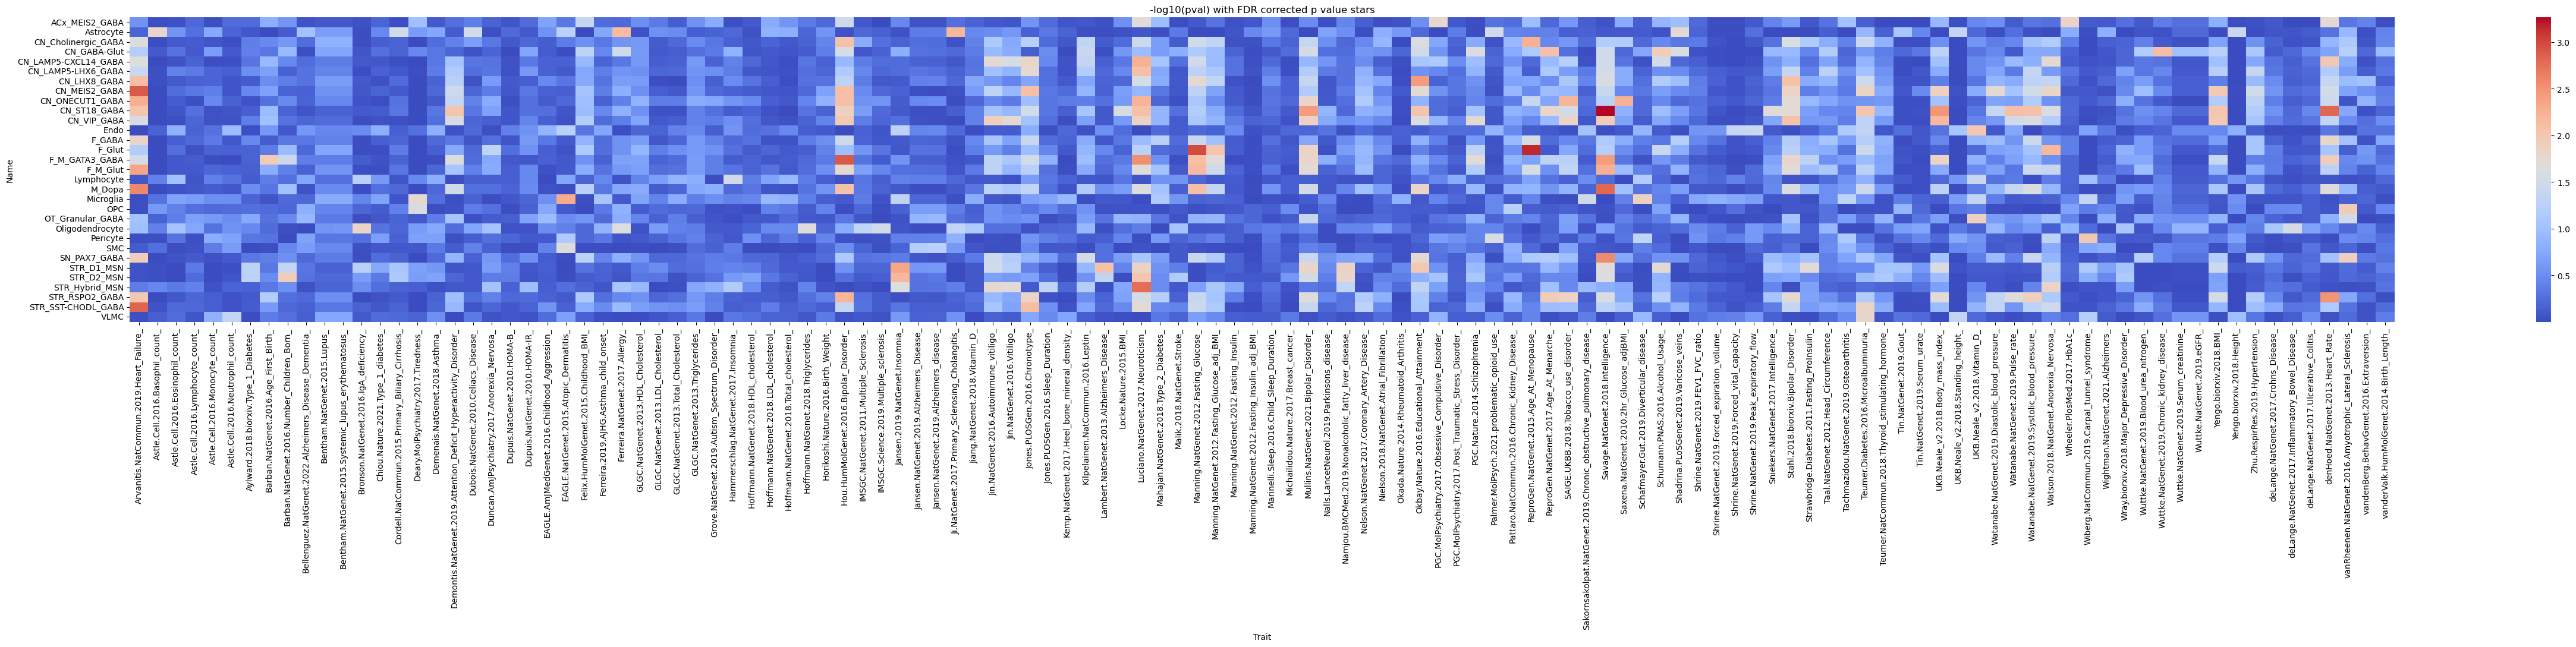

In [15]:
stars = fdr_modified_df.applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(50, 11))
sns.heatmap(modified_df, annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_FDR_corrected.pdf')
plt.show()

